In [1]:
%load_ext autoreload
%autoreload 2

In [12]:
import xarray as xr
import ghibtools as gh
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import seaborn as sns
import pingouin
from compute_global_dataframes import hrv_concat_job
from params import *
from bibliotheque import get_pos, df_baseline
import physio
from configuration import base_folder, base_cmo
import os

In [3]:
hrv = hrv_concat_job.get(global_key).to_dataframe()

In [4]:
units = {'HRV_Mean':'ms',
        'HRV_SD':'ms',
        'HRV_Median':'ms',
        'HRV_Mad':'ms',
        'HRV_CV':None,
        'HRV_MCV':None,
        'HRV_Asymmetry':'ms',
        'HRV_RMSSD':'ms'}

clean_label = {'HRV_Mean':'HRV Mean',
        'HRV_SD':'HRV SD',
        'HRV_Median':'HRV Median',
        'HRV_Mad':'HRV Mad',
        'HRV_CV':'HRV CV',
        'HRV_MCV':'HRV MCV',
        'HRV_Asymmetry':'HRV Asymmetry',
        'HRV_RMSSD':'HRV RMSSD'}

metrics = ['HRV_Mean', 'HRV_SD', 'HRV_Median', 'HRV_Mad',
       'HRV_CV', 'HRV_MCV', 'HRV_Asymmetry', 'HRV_RMSSD']

indexes = ['participant','session']

In [5]:
hrv_baselined = df_baseline(hrv, indexes, metrics)

In [6]:
hrv.columns

Index(['participant', 'session', 'HRV_Mean', 'HRV_SD', 'HRV_Median', 'HRV_Mad',
       'HRV_CV', 'HRV_MCV', 'HRV_Asymmetry', 'HRV_RMSSD', 'stai_state',
       'stai_trait', 'Gender', 'Maia_Mean', 'OAS', 'BMRQ'],
      dtype='object')

In [7]:
hrv

,participant,session,HRV_Mean,HRV_SD,HRV_Median,HRV_Mad,HRV_CV,HRV_MCV,HRV_Asymmetry,HRV_RMSSD,stai_state,stai_trait,Gender,Maia_Mean,OAS,BMRQ
dim_0,,,,,,,,,,,,,,,,
0,P01,baseline,710.594012,49.627612,709.0,44.478067,0.069840,0.062734,-1.594012,44.638931,40,61,F,1.019643,2.666667,2.727273
1,P01,music,736.901496,49.361045,733.0,37.065055,0.066985,0.050566,-3.901496,42.419042,40,61,F,1.019643,2.666667,2.727273
2,P01,odor,767.753989,91.021796,759.5,52.632379,0.118556,0.069299,-8.253989,88.464355,40,61,F,1.019643,2.666667,2.727273
3,P02,baseline,750.078849,85.528176,744.0,97.851746,0.114026,0.131521,-6.078849,57.234754,24,37,F,3.354762,3.066667,3.000000
4,P02,music,750.314143,86.288657,740.0,88.956133,0.115003,0.120211,-10.314143,54.681626,24,37,F,3.354762,3.066667,3.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
85,P30,music,916.568147,54.558175,922.0,47.443271,0.059524,0.051457,5.431853,33.667720,25,29,M,3.071131,2.966667,3.045455
86,P30,odor,947.990491,55.019921,950.0,50.408475,0.058038,0.053062,2.009509,33.400432,25,29,M,3.071131,2.966667,3.045455
87,P31,baseline,809.801351,54.900276,810.0,56.338884,0.067795,0.069554,0.198649,31.887722,29,40,M,2.790774,2.933333,2.681818


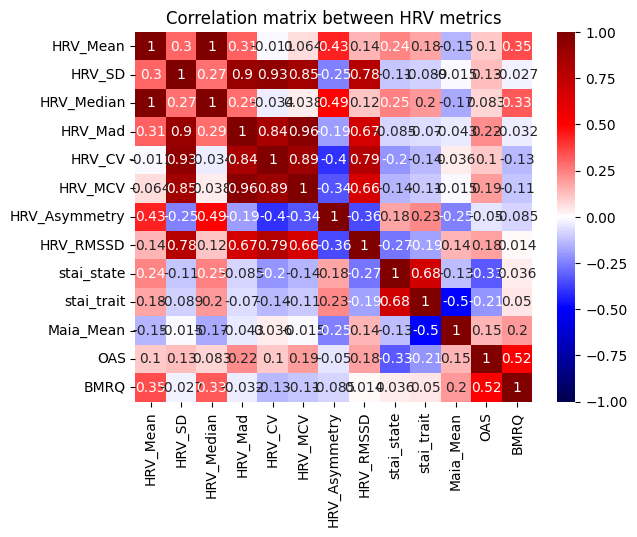

In [8]:
fig, ax = plt.subplots()
sns.heatmap(hrv.corr('spearman',numeric_only = True), annot = True, cmap = 'seismic', vmin = -1, vmax = 1, ax=ax)
ax.set_title('Correlation matrix between HRV metrics')
file = base_folder / 'Figures' / 'HRV' / 'corr_matrix_hrv.png'
fig.savefig(file, bbox_inches = 'tight')
fig.show()

/home/valentin.ghibaudo/.virtualenvs/py3.10_nodegpu/lib/python3.10/site-packages/pingouin/distribution.py:1006: RuntimeWarning: divide by zero encountered in double_scalars
  W = np.product(eig) / (eig.sum() / d) ** d
/home/valentin.ghibaudo/.virtualenvs/py3.10_nodegpu/lib/python3.10/site-packages/pingouin/distribution.py:1006: RuntimeWarning: divide by zero encountered in double_scalars
  W = np.product(eig) / (eig.sum() / d) ** d
/home/valentin.ghibaudo/.virtualenvs/py3.10_nodegpu/lib/python3.10/site-packages/pingouin/distribution.py:1006: RuntimeWarning: divide by zero encountered in double_scalars
  W = np.product(eig) / (eig.sum() / d) ** d


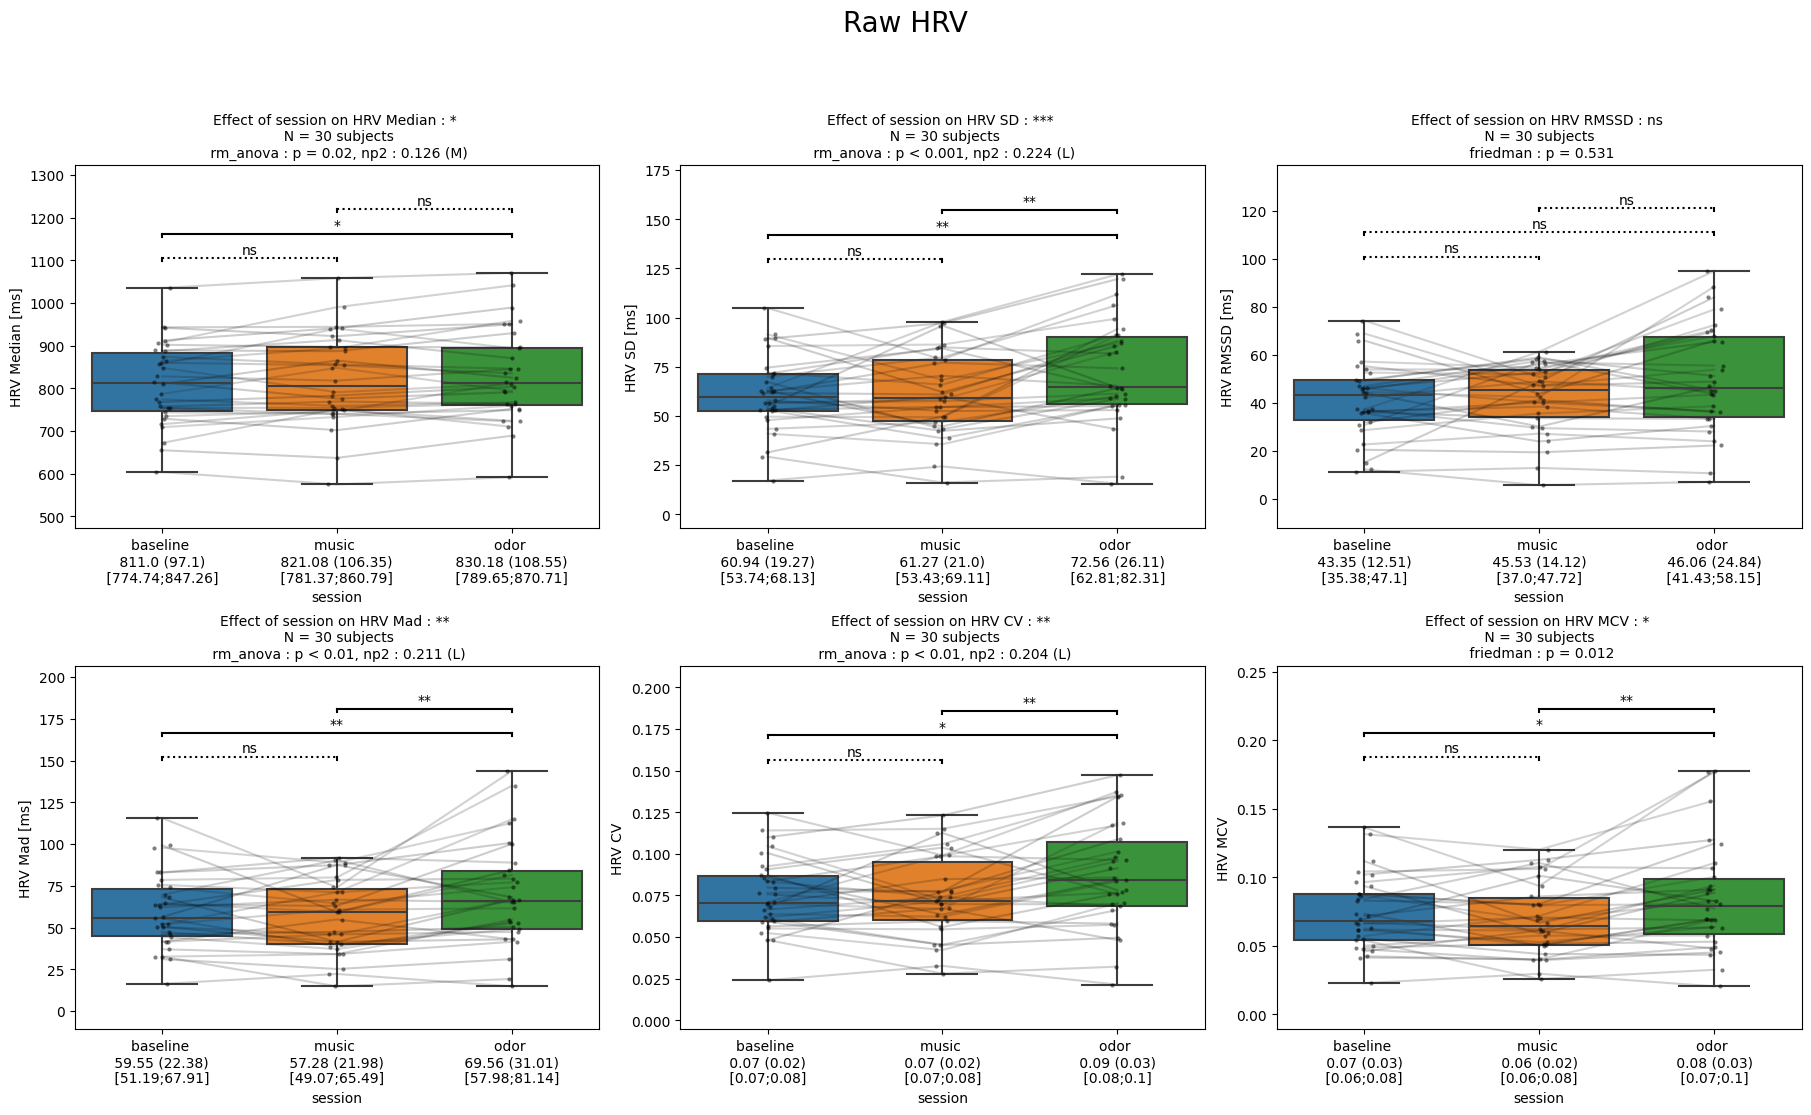

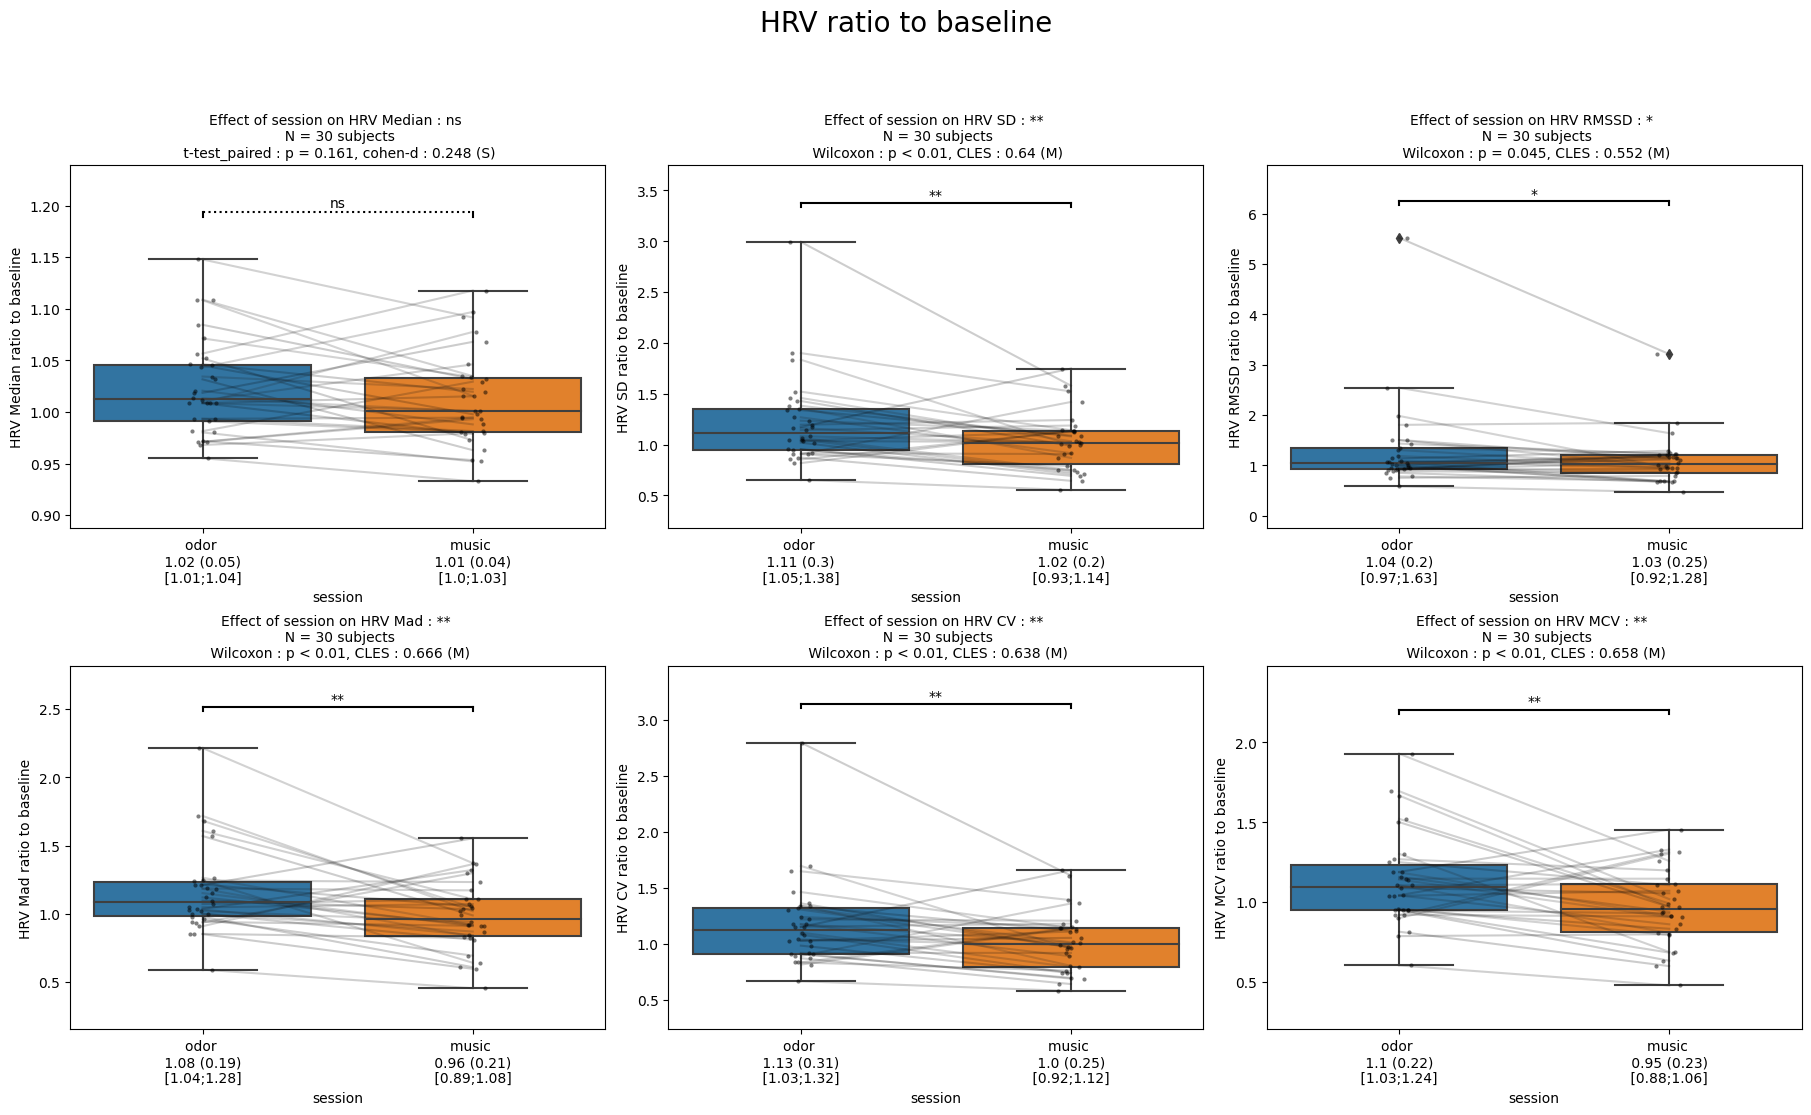

In [9]:
interesting_metrics = ['HRV_Median','HRV_SD','HRV_RMSSD','HRV_Mad','HRV_CV','HRV_MCV']

nrows = 2
ncols = 3
plot_metrics = np.array(interesting_metrics).reshape(nrows, ncols)

for suptitle, df in zip(['Raw HRV','HRV ratio to baseline'],[hrv, hrv_baselined]):
    
    fig, axs = plt.subplots(nrows, ncols, figsize = (18,10), constrained_layout = True)
    fig.suptitle(suptitle, fontsize = 20, y = 1.1)
    
    for c in range(ncols):
        for r in range(nrows):
            ax = axs[r,c]
            metric = plot_metrics[r,c]
            
            if 'ratio' in suptitle:
                outcome_unit = None
            else:
                outcome_unit = units[metric]
                
            
            gh.auto_stats(df=df, 
                          predictor = 'session', 
                          outcome = metric, 
                          design = 'within', 
                          subject = 'participant', 
                          ax=ax, 
                          outcome_clean_label = clean_label[metric], 
                          outcome_unit =  outcome_unit,
                         # order = ['baseline','odor','music'],
                         strip = True,
                         lines = True,
                         xtick_info = True)
            
            if 'ratio' in suptitle:
                ax.set_ylabel(ax.get_ylabel() + ' ratio to baseline')
    file = base_folder / 'Figures' / 'HRV' / f'{suptitle}.png'

    fig.savefig(file, bbox_inches = 'tight')
    fig.show()

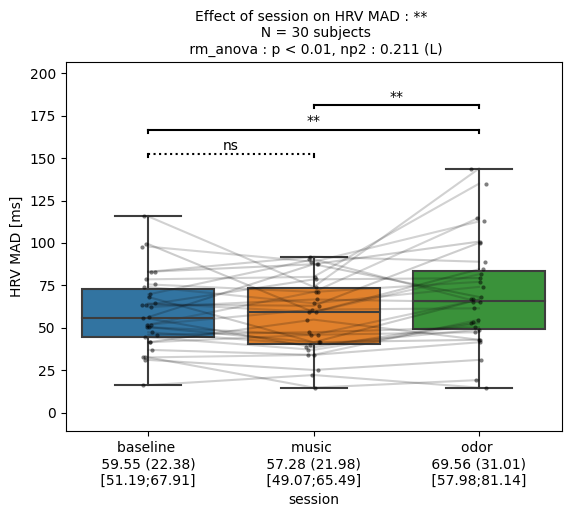

In [10]:

fig, ax = plt.subplots()

            
gh.auto_stats(df=hrv, 
              predictor = 'session', 
              outcome = 'HRV_Mad', 
              design = 'within', 
              subject = 'participant', 
              ax=ax, 
              outcome_clean_label = 'HRV MAD', 
              outcome_unit =  'ms',
             # order = ['baseline','odor','music'],
             strip = True,
             lines = True,
             xtick_info = True)

file = base_folder / 'Figures' / 'HRV' / 'HRV_MAD_clean.png'

fig.savefig(file, bbox_inches = 'tight', dpi = 300)
fig.show()

## FIG SOUTENANCE

/tmp/ipykernel_666966/162492023.py:18: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_yticklabels(ax.get_yticklabels(), fontsize = fontsize)


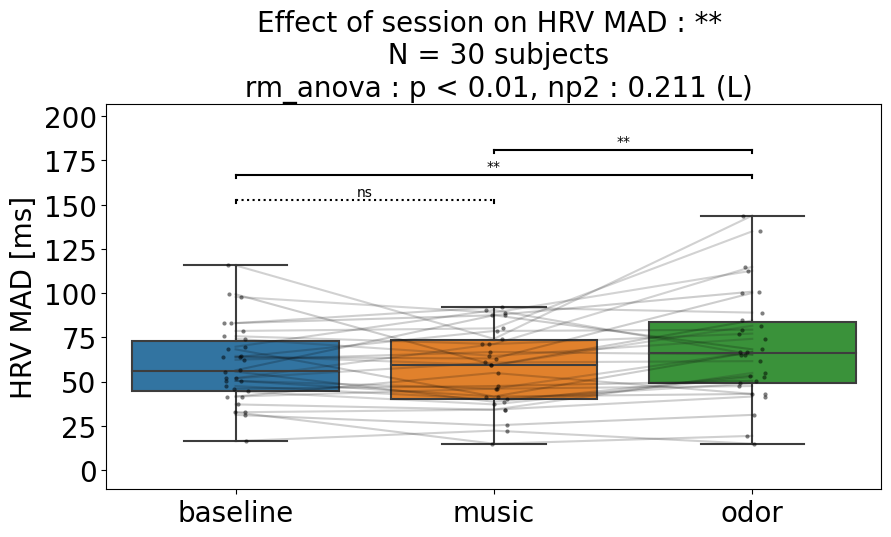

In [13]:
fig , ax = plt.subplots(figsize = (10,5))

fontsize = 20

gh.auto_stats(df = hrv, 
              predictor = 'session', 
              outcome = 'HRV_Mad', 
              design = 'within', 
              subject = 'participant', 
              ax=ax, 
              outcome_clean_label = 'HRV MAD', 
              outcome_unit = 'ms',
             strip = True,
             lines = True,
             xtick_info = False,
             fontsize = fontsize)
ax.set_xticklabels(ax.get_xticklabels(), fontsize = fontsize)
ax.set_yticklabels(ax.get_yticklabels(), fontsize = fontsize)
ax.set_xlabel(None)
ax.set_ylabel(ax.get_ylabel(), fontsize=fontsize)

file =  base_cmo / 'users' / 'ValentinGhibaudo' / 'Rédaction_Thèse' / 'Soutenance_Thèse' / 'figures' / 'emosens3_hrv.png'
fig.savefig(file, bbox_inches = 'tight', dpi = 500)